In [1]:
import os
import json
from PIL import Image
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from PIL import Image
import numpy as np
from kornia.color import RgbToLab
from kornia.color import LabToRgb 
from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt

/home/ghost/Desktop/visopeEnviroment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.rgb2lab = RgbToLab()
        self.lab2rgb = LabToRgb()
        counter = 0

        for i,dir_name in enumerate(os.listdir(root_dir)):
            if i==1000:
                break
                
            dir_path = os.path.join(root_dir, dir_name)
            if os.path.isdir(dir_path):
                json_file = os.path.join(dir_path, 'prompt.json')
                if os.path.exists(json_file):
                    with open(json_file, 'r') as file:
                        data = json.load(file)
                        input_text = data['input']
                        edit_text = data['edit']
                    #print(os.listdir(dir_path))
                    for filename in os.listdir(dir_path):
                        #lets extract for each _0 image, its corresponding _1
                        filename = filename[:-4] # delete  '.jpg'
                        #print(filename)
                        if filename.endswith('_0'):
                            # original image\
                            image_before_name_cut = filename[:-2] # is the 'image before' without _0

                            image_before_name = image_before_name_cut + '_0'
                            image_after_name = image_before_name_cut + '_1'

                            image_before_name = os.path.join(dir_name, f"{image_before_name}.jpg")
                            image_after_name = os.path.join(dir_name, f"{image_after_name}.jpg")
                            #print(image_before_name)
                            #print(image_after_name)


                            self.samples.append((image_before_name, image_after_name, input_text, edit_text))
                else:
                    counter +=1

        #calculate the mean and std of the entire dataset ?
        #typicalli is done to classification, in pix2pix is used -1,1
       # mean = np.mean(self.samples)
        #print(len(self.samples))
        self.transform = transforms.Compose([
            #transforms.Resize((256, 256)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.tensor_to_image = transforms.ToPILImage()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_before_name, image_after_name, input_text, edit_text = self.samples[idx]

        image_before_path = os.path.join(self.root_dir, image_before_name)
        image_after_path = os.path.join(self.root_dir, image_after_name)

        image_before = Image.open(image_before_path).convert('RGB')
        image_before = self.transform(image_before)
        image_before = self.rgb2lab(image_before)

        image_after = Image.open(image_after_path).convert('RGB')
        image_after = self.transform(image_after)
        image_after = self.rgb2lab(image_before)

        return image_before

    def print_image_from_lab(self, image):
        #mean = np.array([0.5, 0.5, 0.5])
       # std = np.array([0.5, 0.5, 0.5])
        #image = image * std[:, None, None] + mean[:, None, None]
       # print(image.shape)
        image = to_pil_image(self.lab2rgb(image).squeeze(0))
       
        #image.show()
        return image

    def print_l_channel(self, image):
        l_channel = image[0,:,:]
        plt.imshow(l_channel, cmap='gray')
        plt.title("L Channel - Grayscale")
        plt.axis('off')
        plt.show()
        #image.show()
        #return image
        

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, root_dir, batch_size=1):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.dataset = CustomDataset(self.root_dir)

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)


In [27]:
dataset_path = os.path.join(os.getcwd(), 'dataset')
print(dataset_path)
test = CustomDataset(dataset_path)

/home/ghost/Desktop/visiopeProject/dataset


In [28]:
len(test)

3455

In [5]:
test[0]

tensor([[[ 42.2079,  38.7731,  39.1552,  ...,  72.6099,  73.4667,  74.7387],
         [ 57.0220,  58.2019,  58.7256,  ...,  70.5464,  72.5461,  73.3513],
         [ 63.4038,  63.4038,  63.0351,  ...,  70.5175,  70.1540,  69.4261],
         ...,
         [ 38.2961,  36.9126,  36.9126,  ...,  58.6937,  58.5822,  59.3436],
         [ 36.4063,  38.5744,  38.2487,  ...,  58.8151,  58.9287,  58.9287],
         [ 37.2411,  38.5744,  37.8341,  ...,  59.5765,  59.0037,  57.8580]],

        [[ 10.4867,  12.1764,  14.4131,  ...,   3.0855,   1.6545,   0.4387],
         [  8.9239,   9.0531,  10.0601,  ...,   4.2597,   2.9135,   1.2490],
         [  9.1816,   9.1816,   9.2493,  ...,   4.5734,   4.6216,   4.7198],
         ...,
         [  5.0541,   6.3993,   6.3993,  ..., -19.0129, -19.7538, -19.7421],
         [  5.8544,   6.2939,   6.8882,  ..., -18.4068, -17.6648, -17.6648],
         [  5.8045,   6.2939,   6.9166,  ..., -18.3982, -17.2507, -17.2628]],

        [[-43.1675, -44.5363, -47.4870,  ...

In [46]:
#test_img = test[0][0][0,:,:].numpy()
#test_img = Image.fromarray(test_img)
#display(test_img)
test[0].unsqueeze(0).squeeze(0).shape

torch.Size([3, 512, 512])

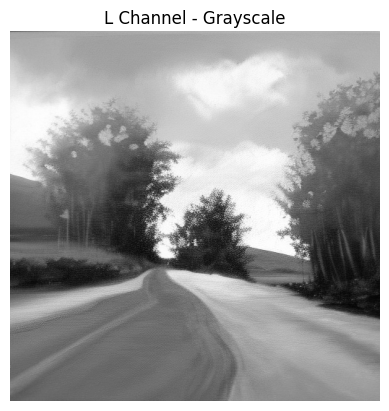

In [7]:
test.print_l_channel(test[0])

In [63]:
#RgbToLab()(test[0][0])

In [64]:
#LabToRgb()(RgbToLab()(test[0][0]))

In [65]:
test[0][0].shape

torch.Size([3, 512, 512])

torch.Size([3, 512, 512])


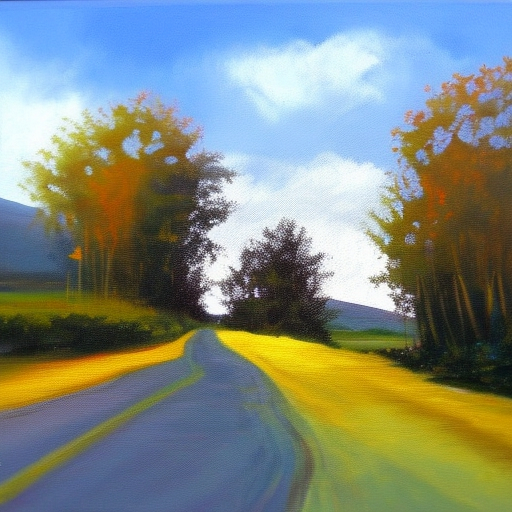

In [8]:
test.print_image_from_lab(test[0])

In [32]:

data_module = CustomDataModule(dataset_path)
data_module.setup()

# Access dataloaders
train_loader = data_module.train_dataloader()
#val_loader = data_module.val_dataloader()
#test_loader = data_module.test_dataloader()

In [10]:
a,b,c = next(iter(train_loader))

ValueError: too many values to unpack (expected 3)

In [11]:
test.print_image(a[0])


AttributeError: 'CustomDataset' object has no attribute 'print_image'

torch.Size([3, 512, 512])


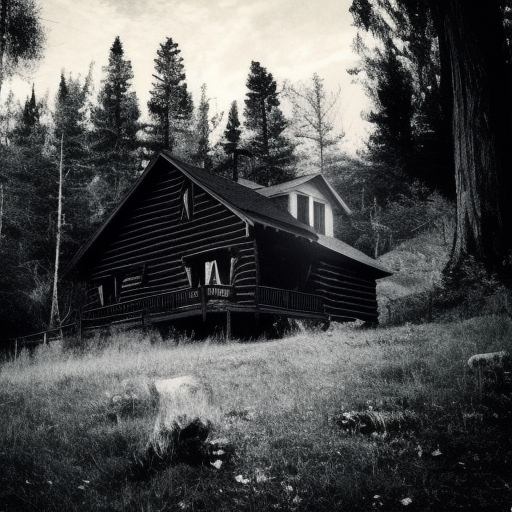

In [49]:
test.print_image(b[0])

In [11]:
c[0]

'have it be a B&W movie'

In [5]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl

In [13]:
test[0][2]

tensor([[-43.1675, -44.5363, -47.4870,  ..., -40.5786, -39.2399, -37.7883],
        [-44.8256, -45.1922, -47.1561,  ..., -42.7476, -41.2257, -39.9703],
        [-49.6975, -49.6975, -49.7344,  ..., -44.9733, -45.0057, -45.0708],
        ...,
        [-19.7693, -20.0674, -20.0674,  ...,  35.4688,  36.8560,  36.7894],
        [-19.0012, -19.9338, -21.0570,  ...,  36.6783,  35.2896,  35.2896],
        [-18.9360, -19.9338, -21.0916,  ...,  36.6114,  35.3984,  35.5000]])

In [7]:
from pytorch_lightning.callbacks import ModelSummary

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, normalize=True, use_dropout=False):
        super(ResidualBlock, self).__init__()
        self.down = down
        layers = []
        if down:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1))
        else:
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))

        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        
        layers.append(nn.ReLU(inplace=True))

        if use_dropout:
            layers.append(nn.Dropout(0.5))

        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1) if down else nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1))

        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))

        self.block = nn.Sequential(*layers)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or down:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0) if down else 
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        x = self.block(x)
        x += identity
        return nn.ReLU(inplace=True)(x)

class GeneratorUNet(pl.LightningModule):
    def __init__(self, in_channels, out_channels):
        super(GeneratorUNet, self).__init__()
        # Define the encoder path with ResNet blocks
        self.down1 = ResidualBlock(in_channels, 64, down=True, normalize=False)
        self.down2 = ResidualBlock(64, 128, down=True)
        self.down3 = ResidualBlock(128, 256, down=True)
        self.down4 = ResidualBlock(256, 512, down=True)
        self.down5 = ResidualBlock(512, 1024, down=True, normalize=False)

        # Define the decoder path with ResNet blocks
        self.up1 = ResidualBlock(1024, 512, down=False)
        self.up2 = ResidualBlock(1024, 256, down=False)  # After concatenation
        self.up3 = ResidualBlock(512, 128, down=False)   # After concatenation
        self.up4 = ResidualBlock(256, 64, down=False)    # After concatenation

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            #nn.Tanh()
        )

    def forward(self, L_channel):
        #x = x[:,0,:,:].unsqueeze(1) #only the L channel
        
        # Encoder
        d1 = self.down1(L_channel)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        
        # Decoder with skip connections
        u1 = self.up1(d5)
        u2 = self.up2(torch.cat((u1, d4), 1))
        u3 = self.up3(torch.cat((u2, d3), 1))
        u4 = self.up4(torch.cat((u3, d2), 1))
        out = self.final(torch.cat((u4, d1),1))
        #print(x.shape)
        #print(out.shape)
        
        return out #torch.cat((x,out),dim=1)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, normalize=True, use_dropout=False):
        super(ResidualBlock, self).__init__()
        self.down = down
        layers = []
        if down:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1))
        else:
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))

        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        
        layers.append(nn.ReLU(inplace=True))

        if use_dropout:
            layers.append(nn.Dropout(0.5))

        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1) if down else nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1))

        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))

        self.block = nn.Sequential(*layers)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or down:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0) if down else 
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        x = self.block(x)
        x += identity
        return nn.ReLU(inplace=True)(x)

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GeneratorUNet, self).__init__()
        # Define the encoder path with ResNet blocks
        self.down1 = ResidualBlock(in_channels, 64, down=True, normalize=False)
        self.down2 = ResidualBlock(64, 128, down=True, use_dropout=True)
        self.down3 = ResidualBlock(128, 256, down=True)

        # Define the decoder path with ResNet blocks
        self.up2 = ResidualBlock(256, 128, down=False)  # After concatenation
        self.up3 = ResidualBlock(256, 128, down=False, use_dropout=True)  # After concatenation
        self.up4 = ResidualBlock(192, 64, down=False)  # After concatenation

        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
            # nn.Tanh()
        )

    def forward(self, L_channel):
        # Encoder
        d1 = self.down1(L_channel)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        
        # Decoder with skip connections
        u1 = self.up2(d3)
        u2 = self.up3(torch.cat((u1, d2), 1))
        u3 = self.up4(torch.cat((u2, d1), 1))
        
        out = self.final(u3)
        
        return out


In [38]:
unet = GeneratorUNet(1,2)


In [39]:
total_params = sum(p.numel() for p in unet.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 2301570


In [18]:
test[0].shape
test.print_image(test[0])


AttributeError: 'CustomDataset' object has no attribute 'print_image'

In [18]:
test[0][0].unsqueeze(0).shape

torch.Size([1, 512, 512])

In [19]:
test[0][0].permute(1,2,0).unsqueeze(0).shape

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [21]:
test[0][0,:,:].unsqueeze(0).shape

torch.Size([1, 512, 512])

In [40]:
result = unet.forward(test[0][0,:,:].unsqueeze(0).unsqueeze(0))

torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 128, 128])


torch.Size([1, 3, 512, 512])


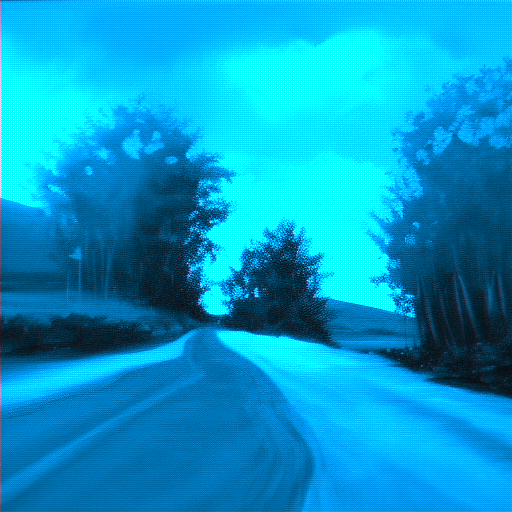

In [137]:
test.print_image_from_lab(result)

In [25]:
result.squeeze(0).shape

torch.Size([3, 512, 512])

torch.Size([3, 512, 512])


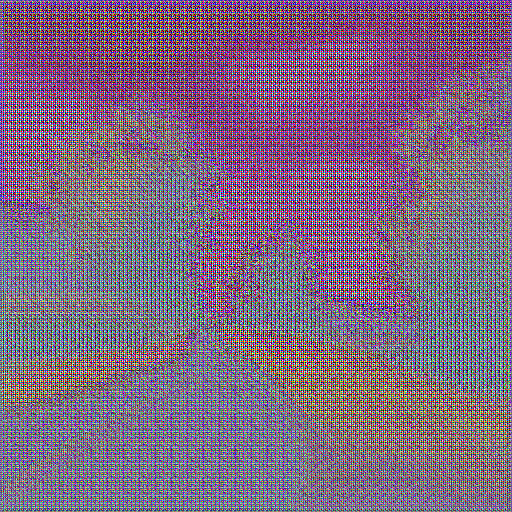

In [26]:
test.print_image(result.squeeze(0).detach())

In [18]:

from torch.nn.utils import spectral_norm

class DiscriminatorPatchGAN(nn.Module):
    def __init__(self, in_channels):
        super(DiscriminatorPatchGAN, self).__init__()
        # Initial layers for the first image type

        # Shared layers after concatenation
        self.shared_layers = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(256, 512, kernel_size=4, padding=1)),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512,1)
        )

    def forward(self, L_channel, ab_channels):
        concatenated_channels = torch.cat((L_channel, ab_channels), dim=1)

        # Pass the combined features through the shared layers
        result = self.shared_layers(concatenated_channels)

        return result


In [43]:
patchgan = DiscriminatorPatchGAN(3)

In [214]:
test[0][0].shape

torch.Size([3, 512, 512])

In [215]:
test[0][0][0,:,:].shape

torch.Size([512, 512])

In [216]:
test[0][0][1:3,:,:].shape

torch.Size([2, 512, 512])

In [45]:
patchgan.forward(test[0][0,:,:].unsqueeze(0).unsqueeze(0),test[0][1:3,:,:].unsqueeze(0)).shape

torch.Size([1, 1])

In [46]:
total_params = sum(p.numel() for p in patchgan.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 2628993


In [218]:
#torch.cat((test[0][0][0,:,:].unsqueeze(0).unsqueeze(0), test[0][0][1:3,:,:].unsqueeze(0)), dim=1)

In [57]:
import torch.nn.functional as F

from pytorch_lightning.loggers import TensorBoardLogger





class CGAN(pl.LightningModule):
    def __init__(self, in_channels, out_channels, lr=0.0002):
        super(CGAN, self).__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        self.log_every_n_steps = 10
        self.rgb2lab = RgbToLab()
        self.lab2rgb = LabToRgb()

        self.generator = GeneratorUNet(in_channels, out_channels)
        self.discriminator = DiscriminatorPatchGAN(out_channels + 1)
        self.lr = lr

    def forward(self, x):
        return self.generator(x)

    def configure_optimizers(self):
        gen_optimizer = torch.optim.Adam(self.generator.parameters(), lr=self.lr)
        dis_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr)
        return [gen_optimizer, dis_optimizer], []


    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)


    def mse_loss(before_image,after_image):
        return nn.MSELoss(before_image,after_image)

    def training_step(self, batch):
        image_lab = batch  # Assuming 'batch' is a tensor with shape [batch_size, 3, H, W]

        # Splitting LAB image into L and ab channels
        image_L_channel_batch = image_lab[:, 0, :, :].unsqueeze(1)  # [batch_size, 1, H, W]
        image_ab_channel_batch = image_lab[:, 1:3, :, :]  # [batch_size, 2, H, W]

        optimizer_g, optimizer_d = self.optimizers()

        # Train generator
        optimizer_g.zero_grad()
        self.toggle_optimizer(optimizer_g)
    
        # Generate ab channels from L channel
        generated_ab_channels = self.generator(image_L_channel_batch)

        # Calculate loss for generator
        g_loss = self.adversarial_loss(self.discriminator(image_L_channel_batch, generated_ab_channels), torch.ones(batch.size(0), 1, device=self.device))
        self.manual_backward(g_loss)
        optimizer_g.step()
        self.untoggle_optimizer(optimizer_g)

        # Log sampled images for visualization
        if self.current_epoch % self.log_every_n_steps == 0:
            # Log both generated and real images for comparison
            real_sample_imgs = torch.cat((image_L_channel_batch[:6], image_ab_channel_batch[:6]), dim=1)
            generated_sample_imgs = torch.cat((image_L_channel_batch[:6], generated_ab_channels[:6]), dim=1)
            
            real_grid = torchvision.utils.make_grid(self.lab2rgb(real_sample_imgs.squeeze(0)) )
            generated_grid = torchvision.utils.make_grid(self.lab2rgb(generated_sample_imgs.squeeze(0)) )

            self.logger.experiment.add_image("real_images", real_grid, global_step=self.global_step)
            self.logger.experiment.add_image("generated_images", generated_grid, global_step=self.global_step)


        # Train discriminator
        optimizer_d.zero_grad()
        self.toggle_optimizer(optimizer_d)
    
        # Real images
        real_output = self.discriminator(image_L_channel_batch, image_ab_channel_batch)
        real_loss = self.adversarial_loss(real_output, torch.ones(real_output.size(0), 1, device=self.device))

        # Fake images
        fake_output = self.discriminator(image_L_channel_batch, generated_ab_channels.detach())  # detach to avoid training G on these labels
        fake_loss = self.adversarial_loss(fake_output, torch.zeros(fake_output.size(0), 1, device=self.device))

        # Combine losses
        d_loss = (real_loss + fake_loss) / 2
        self.manual_backward(d_loss)
        optimizer_d.step()
        self.untoggle_optimizer(optimizer_d)

        # Logging losses
        self.log("g_loss", g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("d_loss", d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'val_g_loss': g_loss, 'val_d_loss': d_loss}

        
    def validation_step(self, batch, batch_idx):
        image_lab = batch  # Assuming 'batch' is a tensor with shape [batch_size, 3, H, W]

        # Splitting LAB image into L and ab channels
        image_L_channel_batch = image_lab[:, 0, :, :].unsqueeze(1)  # [batch_size, 1, H, W]
        image_ab_channel_batch = image_lab[:, 1:3, :, :]  # [batch_size, 2, H, W]

        # Generate ab channels from L channel
        generated_ab_channels = self.generator(image_L_channel_batch)

        # Calculate generator loss (for validation, no backward or step)
        g_loss = self.adversarial_loss(self.discriminator(image_L_channel_batch, generated_ab_channels), torch.ones(batch.size(0), 1, device=self.device))

        # Real images discriminator validation
        real_output = self.discriminator(image_L_channel_batch, image_ab_channel_batch)
        real_loss = self.adversarial_loss(real_output, torch.ones(real_output.size(0), 1, device=self.device))

        # Fake images discriminator validation
        fake_output = self.discriminator(image_L_channel_batch, generated_ab_channels)
        fake_loss = self.adversarial_loss(fake_output, torch.zeros(fake_output.size(0), 1, device=self.device))

        # Combine losses for discriminator
        d_loss = (real_loss + fake_loss) / 2

        # Return validation losses for logging
        self.log('val_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)

        # Optionally, add image logging to visualize validation performance
        if batch_idx == 0:  # log images from the first batch of each validation epoch
            sample_imgs = torch.cat((image_L_channel_batch[0][0], generated_ab_channels[0][0]), dim=1)
            grid = torchvision.utils.make_grid(sample_imgs)
            logger.experiment.add_image("generated_images", grid, global_step=self.global_step)

        return {'val_g_loss': g_loss, 'val_d_loss': d_loss}
# Dumm

In [63]:
del cgan

NameError: name 'cgan' is not defined

In [62]:
torch.cuda.empty_cache()

In [67]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14883), started 0:00:42 ago. (Use '!kill 14883' to kill it.)

In [68]:
#train_loader = data_module.train_dataloader()
#val_loader = data_module.val_dataloader()
#test_loader = data_module.test_dataloader()

# Initialize your CGAN model
cgan = CGAN(1, 2)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(accelerator="gpu", max_epochs=10, logger=TensorBoardLogger("logs", name="CGAN_new_experiment"), callbacks=[ModelSummary(max_depth=1)])
# Start training loop
print("Starting Training Loop...")
trainer.fit(cgan, train_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ghost/Desktop/visopeEnviroment/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                  | Params
--------------------------------------------------------
0 | rgb2lab       | RgbToLab              | 0     
1 | lab2rgb       | LabToRgb              | 0     
2 | generator     | GeneratorUNet         | 31.4 M
3 | discriminator | DiscriminatorPatchGAN | 2.8 M 
--------------------------------------------------------
34.1 M    Trainable params
0         Non-trainable para

Starting Training Loop...
Epoch 0:   0%|                                         | 0/3455 [42:56<?, ?it/s]
Epoch 9: 100%|█| 3455/3455 [17:16<00:00,  3.33it/s, v_num=1, g_loss_step=1.030, 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 3455/3455 [17:17<00:00,  3.33it/s, v_num=1, g_loss_step=1.030, 


In [70]:
trainer.save_checkpoint("example.ckpt")

In [ ]:
#example:
import torch

# Initialize example tensors
image_features = torch.randn(2, 4, 2, 2) # Shape [2, 1024, 16, 16]
print(image_features)
text_embeddings = torch.tensor([[1,2,3],[4,5,6]])         # Shape [2, 383]
print(text_embeddings)
# Expand the text embeddings to match the spatial dimensions of the image features
# First, add two singleton dimensions so that it matches the image feature shape for broadcasting
text_embeddings_expanded = text_embeddings[:, :, None, None].expand(-1, -1, 2, 2)  # Shape [2, 383, 16, 16]

# Concatenate along the channel dimension to combine text info with image features
combined_features = torch.cat((image_features, text_embeddings_expanded), dim=1)  # Shape [2, 1024+383, 16, 16]

print("Combined features shape:", combined_features.shape)
print(combined_features)

In [ ]:
# Initialize example tensors
image_features_1 = torch.randn(2, 10, 2, 2) # Shape [2, 1024, 16, 16]
image_features_2 = torch.randn(2, 4, 2, 2) # Shape [2, 1024, 16, 16]


concatenated_tensor = torch.cat((image_features_1, image_features_2), dim=-1)
print("Combined features shape:", concatenated_tensor.shape)
print(concatenated_tensor)